In [44]:
from src import PINNViga
from src import Carga
from src import Apoio
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import time

VIGA BIAPOIADA

In [3]:
## SEÇÃO DA VIGA

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

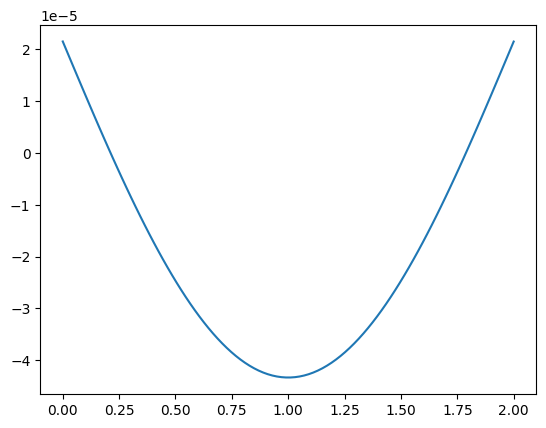

In [29]:
## FORÇANDO A CONTINUIDADE EM UM MESMO MODELO:

import copy
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

class PINNViga(nn.Module):
    def __init__(self):
        super(PINNViga, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)
    
viga = PINNViga()
optimizer = torch.optim.Adam(viga.parameters(), lr=0.001)

tam = 100
torch.manual_seed(1)
min_val = 0
max_val = 1
x_scaled = min_val + (max_val - min_val) * torch.rand(tam, 1)
x = x_scaled.requires_grad_(True)

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

u_ref = q * (L**4) / EI

num_epochs = 501

for epoch in range(num_epochs):
    optimizer.zero_grad()

    u = viga(x)

    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), create_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, torch.ones_like(u_xxx), create_graph=True)[0]
    
    loss_pde = torch.mean((u_xxxx - 1) ** 2)

    ## loss bc

    loss_bc = 0

    # apoio esquerda:

    x0 = torch.tensor([0.0], requires_grad=True)
    u_0 = viga(x0)

    u0_x = torch.autograd.grad(u_0, x0, torch.ones_like(u_0), create_graph=True)[0]
    u0_xx = torch.autograd.grad(u0_x, x0, torch.ones_like(u0_x), create_graph=True)[0]
    u0_xxx = torch.autograd.grad(u0_xx, x0, torch.ones_like(u0_xx), create_graph=True)[0]

    loss_bc += (u_0)**2
    loss_bc += (u0_xx)**2

    # apoio direita:

    x1 = torch.tensor([1.0], requires_grad=True)
    u_1 = viga(x1)

    u1_x = torch.autograd.grad(u_1, x1, torch.ones_like(u_1), create_graph=True)[0]
    u1_xx = torch.autograd.grad(u1_x, x1, torch.ones_like(u1_x), create_graph=True)[0]
    u1_xxx = torch.autograd.grad(u1_xx, x1, torch.ones_like(u1_xx), create_graph=True)[0]

    loss_bc += (u_1)**2
    loss_bc += (u1_xx)**2

    # apoio MEIO:

    x2 = torch.tensor([0.5], requires_grad=True)
    u_2 = viga(x2)

    u2_x = torch.autograd.grad(u_2, x2, torch.ones_like(u_2), create_graph=True)[0]
    u2_xx = torch.autograd.grad(u2_x, x2, torch.ones_like(u2_x), create_graph=True)[0]
    u2_xxx = torch.autograd.grad(u2_xx, x2, torch.ones_like(u2_xx), create_graph=True)[0]

    loss_bc += (u_2)**2
    # loss_bc += (u2_xx)**2

    loss = loss_pde + loss_bc

    loss.backward()            
    optimizer.step()

x_plot = torch.linspace(0, 1, tam).view(-1,1)
u_plot_star = viga(x_plot).detach().numpy()
viga.u_plot = u_plot_star * u_ref
viga.x_plot = (x_plot.numpy() * L)

plt.plot(viga.x_plot, viga.u_plot)

In [67]:
## FORÇANDO A CONTINUIDADE COM MODELO UNICO:

import copy
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

class PINNViga(nn.Module):
    def __init__(self):
        super(PINNViga, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)
    
b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

u_ref = q * (L**4) / EI
    
viga = PINNViga()
optimizer = torch.optim.Adam(viga.parameters(), lr=0.001)

# viga_dir = PINNViga()
# optimizer_dir = torch.optim.Adam(viga_dir.parameters(), lr=0.001)

tam = 100
torch.manual_seed(1)
min_val = 0
max_val = 1

x_esq_scaled = min_val + (max_val - min_val) * torch.rand(tam, 1)
x_esq = x_esq_scaled.requires_grad_(True)

x_dir_scaled = min_val + (max_val - min_val) * torch.rand(tam, 1)
x_dir = x_dir_scaled.requires_grad_(True)

num_epochs = 1001

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # optimizer_dir.zero_grad()

    ## LOSS PDE

    ## VIGA DA ESQUERDA

    u_esq = viga(x_esq)

    u1_esq = torch.autograd.grad(u_esq, x_esq, torch.ones_like(u_esq), create_graph=True)[0]
    u2_esq = torch.autograd.grad(u1_esq, x_esq, torch.ones_like(u1_esq), create_graph=True)[0]
    u3_esq = torch.autograd.grad(u2_esq, x_esq, torch.ones_like(u2_esq), create_graph=True)[0]
    u4_esq = torch.autograd.grad(u3_esq, x_esq, torch.ones_like(u3_esq), create_graph=True)[0]
    
    loss_pde_esq = torch.mean((u4_esq - 1) ** 2)

    ## VIGA DA DIREITA

    u_dir = viga(x_dir)

    u1_dir = torch.autograd.grad(u_dir, x_dir, torch.ones_like(u_dir), create_graph=True)[0]
    u2_dir = torch.autograd.grad(u1_dir, x_dir, torch.ones_like(u1_dir), create_graph=True)[0]
    u3_dir = torch.autograd.grad(u2_dir, x_dir, torch.ones_like(u2_dir), create_graph=True)[0]
    u4_dir = torch.autograd.grad(u3_dir, x_dir, torch.ones_like(u3_dir), create_graph=True)[0]
    
    loss_pde_dir = torch.mean((u4_dir - 1) ** 2)

    # LOSS BC

    ## VIGA DA ESQUERDA

    loss_bc_esq = 0

    # apoio esquerda:

    x0_esq_esq = torch.tensor([0.0], requires_grad=True)
    c0_esq_esq = viga(x0_esq_esq)

    c1_esq_esq = torch.autograd.grad(c0_esq_esq, x0_esq_esq, torch.ones_like(c0_esq_esq), create_graph=True)[0]
    c2_esq_esq = torch.autograd.grad(c1_esq_esq, x0_esq_esq, torch.ones_like(c1_esq_esq), create_graph=True)[0]
    c3_esq_esq = torch.autograd.grad(c2_esq_esq, x0_esq_esq, torch.ones_like(c2_esq_esq), create_graph=True)[0]

    loss_bc_esq += (c0_esq_esq)**2
    loss_bc_esq += (c2_esq_esq)**2

    # apoio direita:

    x0_dir_esq = torch.tensor([1.0], requires_grad=True)
    c0_dir_esq = viga(x0_dir_esq)

    c1_dir_esq = torch.autograd.grad(c0_dir_esq, x0_dir_esq, torch.ones_like(c0_dir_esq), create_graph=True)[0]
    c2_dir_esq = torch.autograd.grad(c1_dir_esq, x0_dir_esq, torch.ones_like(c1_dir_esq), create_graph=True)[0]
    c3_dir_esq = torch.autograd.grad(c2_dir_esq, x0_dir_esq, torch.ones_like(c2_dir_esq), create_graph=True)[0]

    loss_bc_esq += (c0_dir_esq)**2
    # loss_bc_esq += (c2_dir_esq)**2

    ## VIGA DA DIREITA

    loss_bc_dir = 0

    # apoio esquerda:

    x0_esq_dir = torch.tensor([0.0], requires_grad=True)
    c0_esq_dir = viga(x0_esq_dir)

    c1_esq_dir = torch.autograd.grad(c0_esq_dir, x0_esq_dir, torch.ones_like(c0_esq_dir), create_graph=True)[0]
    c2_esq_dir = torch.autograd.grad(c1_esq_dir, x0_esq_dir, torch.ones_like(c1_esq_dir), create_graph=True)[0]
    c3_esq_dir = torch.autograd.grad(c2_esq_dir, x0_esq_dir, torch.ones_like(c2_esq_dir), create_graph=True)[0]

    loss_bc_dir += (c0_esq_dir)**2
    # loss_bc_dir += (c2_esq_dir)**2

    # apoio direita:

    x0_dir_dir = torch.tensor([1.0], requires_grad=True)
    c0_dir_dir = viga(x0_dir_dir)

    c1_dir_dir = torch.autograd.grad(c0_dir_dir, x0_dir_dir, torch.ones_like(c0_dir_dir), create_graph=True)[0]
    c2_dir_dir = torch.autograd.grad(c1_dir_dir, x0_dir_dir, torch.ones_like(c1_dir_dir), create_graph=True)[0]
    c3_dir_dir = torch.autograd.grad(c2_dir_dir, x0_dir_dir, torch.ones_like(c2_dir_dir), create_graph=True)[0]

    loss_bc_dir += (c0_dir_dir)**2
    loss_bc_dir += (c2_dir_dir)**2

    ## LOSS CONTINUIDADE

    loss_cont = 0

    x0_cont_esq = torch.tensor([1.0], requires_grad=True)
    x0_cont_dir = torch.tensor([0.0], requires_grad=True)

    cont_esq = viga(x0_cont_esq)
    cont1_esq = torch.autograd.grad(cont_esq, x0_cont_esq, torch.ones_like(cont_esq), create_graph=True)[0]
    cont2_esq = torch.autograd.grad(cont1_esq, x0_cont_esq, torch.ones_like(cont1_esq), create_graph=True)[0]

    cont_dir = viga(x0_cont_dir)
    cont1_dir = torch.autograd.grad(cont_dir, x0_cont_dir, torch.ones_like(cont_dir), create_graph=True)[0]
    cont2_dir = torch.autograd.grad(cont1_dir, x0_cont_dir, torch.ones_like(cont1_dir), create_graph=True)[0]

    # loss_cont += (cont_esq - cont_dir) ** 2
    loss_cont += (cont1_esq - cont1_dir) ** 2
    loss_cont += (cont2_esq - cont2_dir) ** 2

    loss = loss_bc_esq + loss_pde_esq + loss_cont + loss_bc_dir + loss_pde_dir
    loss.backward()

    if epoch % int(num_epochs / 10) == 0:
        # print(f"Epoch {epoch}, Loss: {loss.item():.12f}, PDE Loss: {loss_pde.item():.12f}, BC Loss: {loss_bc.item():.12f}")
        print(f"Epoch {epoch}")

    # loss_dir = loss_bc_dir + loss_pde_dir
    # loss_dir.backward()

    # loss.backward()            
    optimizer.step()

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000


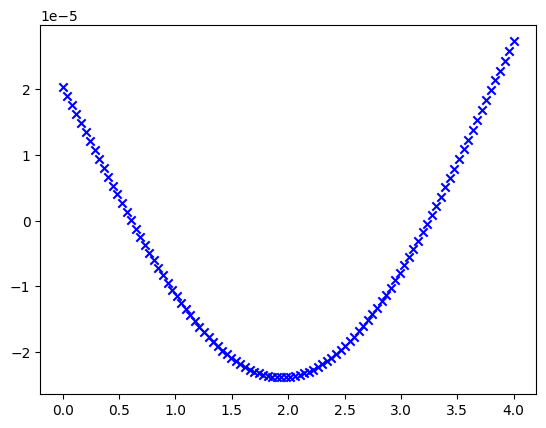

In [68]:
x_plot = torch.linspace(0, 1, tam).view(-1,1)

u_esq_plot_star = viga(x_plot).detach().numpy()
viga.u_plot = u_esq_plot_star * u_ref
viga.x_plot = (x_plot.numpy() * 2*L)

# u_dir_plot_star = viga_dir(x_plot).detach().numpy()
# viga_dir.u_plot = u_dir_plot_star * u_ref
# viga_dir.x_plot = (2 + x_plot.numpy() * L)

def y1(x):
    return (q / (EI)) * (x ** 4 - 2 * L * x ** 3 + L ** 3 * x)

def y2(x):
    if x <= L / 4:
        return - (q * L / (EI)) * (4 * x ** 3 - 3 * L ** 2 * x)
    else:
        x = L - x
        return - (5 * q * L / (8 *EI)) * (4 * x ** 3 - 3 * L ** 2 * x)

# y_anal1 = [y1(x) + y2(0) for x in viga_esq.x_plot]
# y_anal2 = [y_anal1[- k] for k in range(len(y_anal1))]

plt.scatter(viga.x_plot, viga.u_plot, color = 'blue', marker='x')
# plt.scatter(viga_dir.x_plot, viga_dir.u_plot, color = 'blue', marker='x')
# plt.plot(viga_esq.x_plot, y_anal1, color = 'red')
# plt.plot(viga_esq.x_plot + L, y_anal2, color = 'red')

In [71]:
## FORÇANDO A CONTINUIDADE COM MODELOS DIFERENTES:

import copy
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

class PINNViga(nn.Module):
    def __init__(self):
        super(PINNViga, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)
    
b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I
q = -10e3
L = 2

u_ref = q * (L**4) / EI
    
viga_esq = PINNViga()
optimizer_esq = torch.optim.Adam(viga_esq.parameters(), lr=0.001)

viga_dir = PINNViga()
optimizer_dir = torch.optim.Adam(viga_dir.parameters(), lr=0.001)

tam = 100
torch.manual_seed(1)
min_val = 0
max_val = 1

x_esq_scaled = min_val + (max_val - min_val) * torch.rand(tam, 1)
x_esq = x_esq_scaled.requires_grad_(True)

x_dir_scaled = min_val + (max_val - min_val) * torch.rand(tam, 1)
x_dir = x_dir_scaled.requires_grad_(True)

num_epochs = 2001

for epoch in range(num_epochs):

    optimizer_esq.zero_grad()
    optimizer_dir.zero_grad()

    ## LOSS PDE

    ## VIGA DA ESQUERDA

    u_esq = viga_esq(x_esq)

    u1_esq = torch.autograd.grad(u_esq, x_esq, torch.ones_like(u_esq), create_graph=True)[0]
    u2_esq = torch.autograd.grad(u1_esq, x_esq, torch.ones_like(u1_esq), create_graph=True)[0]
    u3_esq = torch.autograd.grad(u2_esq, x_esq, torch.ones_like(u2_esq), create_graph=True)[0]
    u4_esq = torch.autograd.grad(u3_esq, x_esq, torch.ones_like(u3_esq), create_graph=True)[0]
    
    loss_pde_esq = torch.mean((u4_esq - 1) ** 2)

    ## VIGA DA DIREITA

    u_dir = viga_dir(x_dir)

    u1_dir = torch.autograd.grad(u_dir, x_dir, torch.ones_like(u_dir), create_graph=True)[0]
    u2_dir = torch.autograd.grad(u1_dir, x_dir, torch.ones_like(u1_dir), create_graph=True)[0]
    u3_dir = torch.autograd.grad(u2_dir, x_dir, torch.ones_like(u2_dir), create_graph=True)[0]
    u4_dir = torch.autograd.grad(u3_dir, x_dir, torch.ones_like(u3_dir), create_graph=True)[0]
    
    loss_pde_dir = torch.mean((u4_dir - 1) ** 2)

    # LOSS BC

    ## VIGA DA ESQUERDA

    loss_bc_esq = 0

    # apoio esquerda:

    x0_esq_esq = torch.tensor([0.0], requires_grad=True)
    c0_esq_esq = viga_esq(x0_esq_esq)

    c1_esq_esq = torch.autograd.grad(c0_esq_esq, x0_esq_esq, torch.ones_like(c0_esq_esq), create_graph=True)[0]
    c2_esq_esq = torch.autograd.grad(c1_esq_esq, x0_esq_esq, torch.ones_like(c1_esq_esq), create_graph=True)[0]
    c3_esq_esq = torch.autograd.grad(c2_esq_esq, x0_esq_esq, torch.ones_like(c2_esq_esq), create_graph=True)[0]

    loss_bc_esq += (c0_esq_esq)**2
    loss_bc_esq += (c2_esq_esq)**2

    # apoio direita:

    x0_dir_esq = torch.tensor([1.0], requires_grad=True)
    c0_dir_esq = viga_esq(x0_dir_esq)

    c1_dir_esq = torch.autograd.grad(c0_dir_esq, x0_dir_esq, torch.ones_like(c0_dir_esq), create_graph=True)[0]
    c2_dir_esq = torch.autograd.grad(c1_dir_esq, x0_dir_esq, torch.ones_like(c1_dir_esq), create_graph=True)[0]
    c3_dir_esq = torch.autograd.grad(c2_dir_esq, x0_dir_esq, torch.ones_like(c2_dir_esq), create_graph=True)[0]

    loss_bc_esq += (c0_dir_esq)**2
    # loss_bc_esq += (c2_dir_esq)**2

    ## VIGA DA DIREITA

    loss_bc_dir = 0

    # apoio esquerda:

    x0_esq_dir = torch.tensor([0.0], requires_grad=True)
    c0_esq_dir = viga_dir(x0_esq_dir)

    c1_esq_dir = torch.autograd.grad(c0_esq_dir, x0_esq_dir, torch.ones_like(c0_esq_dir), create_graph=True)[0]
    c2_esq_dir = torch.autograd.grad(c1_esq_dir, x0_esq_dir, torch.ones_like(c1_esq_dir), create_graph=True)[0]
    c3_esq_dir = torch.autograd.grad(c2_esq_dir, x0_esq_dir, torch.ones_like(c2_esq_dir), create_graph=True)[0]

    loss_bc_dir += (c0_esq_dir)**2
    # loss_bc_dir += (c2_esq_dir)**2

    # apoio direita:

    x0_dir_dir = torch.tensor([1.0], requires_grad=True)
    c0_dir_dir = viga_dir(x0_dir_dir)

    c1_dir_dir = torch.autograd.grad(c0_dir_dir, x0_dir_dir, torch.ones_like(c0_dir_dir), create_graph=True)[0]
    c2_dir_dir = torch.autograd.grad(c1_dir_dir, x0_dir_dir, torch.ones_like(c1_dir_dir), create_graph=True)[0]
    c3_dir_dir = torch.autograd.grad(c2_dir_dir, x0_dir_dir, torch.ones_like(c2_dir_dir), create_graph=True)[0]

    loss_bc_dir += (c0_dir_dir)**2
    loss_bc_dir += (c2_dir_dir)**2

    ## LOSS CONTINUIDADE

    loss_cont = 0

    x0_cont_esq = torch.tensor([1.0], requires_grad=True)
    x0_cont_dir = torch.tensor([0.0], requires_grad=True)

    cont_esq = viga_esq(x0_cont_esq)
    cont1_esq = torch.autograd.grad(cont_esq, x0_cont_esq, torch.ones_like(cont_esq), create_graph=True)[0]
    cont2_esq = torch.autograd.grad(cont1_esq, x0_cont_esq, torch.ones_like(cont1_esq), create_graph=True)[0]

    cont_dir = viga_dir(x0_cont_dir)
    cont1_dir = torch.autograd.grad(cont_dir, x0_cont_dir, torch.ones_like(cont_dir), create_graph=True)[0]
    cont2_dir = torch.autograd.grad(cont1_dir, x0_cont_dir, torch.ones_like(cont1_dir), create_graph=True)[0]

    # loss_cont += (cont_esq - cont_dir) ** 2
    loss_cont += (cont1_esq - cont1_dir) ** 2
    loss_cont += (cont2_esq - cont2_dir) ** 2

    loss_esq = loss_bc_esq + loss_pde_esq + loss_cont
    loss_esq.backward()

    loss_dir = loss_bc_dir + loss_pde_dir
    loss_dir.backward()

    if epoch % int(num_epochs / 10) == 0:
        # print(f"Epoch {epoch}, Loss: {loss.item():.12f}, PDE Loss: {loss_pde.item():.12f}, BC Loss: {loss_bc.item():.12f}")
        print(f"Epoch {epoch}")

    # loss.backward()            
    optimizer_esq.step()
    optimizer_dir.step()

Epoch 0
Epoch 200
Epoch 400
Epoch 600
Epoch 800
Epoch 1000
Epoch 1200
Epoch 1400
Epoch 1600
Epoch 1800
Epoch 2000


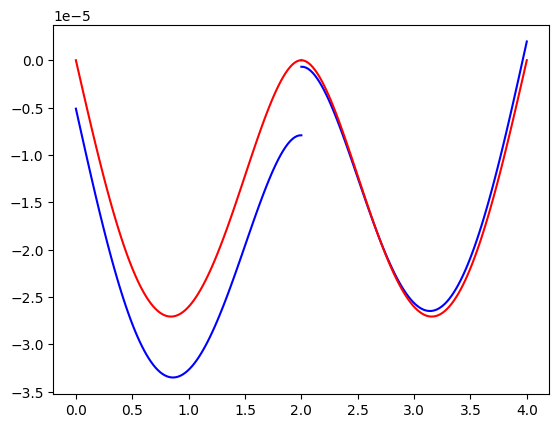

In [72]:
x_plot = torch.linspace(0, 1, tam).view(-1,1)

u_esq_plot_star = viga_esq(x_plot).detach().numpy()
viga_esq.u_plot = u_esq_plot_star * u_ref
viga_esq.x_plot = (x_plot.numpy() * L)

u_dir_plot_star = viga_dir(x_plot).detach().numpy()
viga_dir.u_plot = u_dir_plot_star * u_ref
viga_dir.x_plot = (2 + x_plot.numpy() * L)

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I
q = -10e3
L = 2

def ycalc(x):
    return - (1 / EI) * ((3 * q * (2 * L) * (x ** 3) / 96) - (q * (x ** 4) / 24) - (q * ((2 * L) ** 3) * x / 384))

valores_y = [ycalc(x) for x in viga_esq.x_plot]
valores_y2 = [valores_y[-k] for k in range(1, len(valores_y) + 1)]

# plt.scatter(viga_esq.x_plot, viga_esq.u_plot, marker = 'x', color = 'blue')
# plt.scatter(viga_dir.x_plot, viga_dir.u_plot, marker = 'x', color = 'blue')
plt.plot(viga_esq.x_plot, viga_esq.u_plot, color = 'blue')
plt.plot(viga_dir.x_plot, viga_dir.u_plot, color = 'blue')
plt.plot(viga_esq.x_plot, valores_y, color = 'red')
plt.plot(viga_dir.x_plot, valores_y2, color = 'red')
# plt.ylim(-1e-4, 1e-6)
# plt.ylim(-5e-6, 1e-6)